In [ ]:
import numpy as np
import healpy as hp

# Set the number of sources and the coordinates for the input
nres = 1000 # number of theta/phi bins (so nres**2 total)
nside = 16
npix = hp.nside2npix(nside)

theta = np.hstack(np.repeat(np.linspace(0, np.pi, nres), nres).reshape(nres, nres))
phi = np.hstack(np.repeat(np.linspace(0, 2*np.pi, nres), nres).reshape(nres, nres).T)
beamthetastd = 0.075
beamphistd = 0.1
beammu = np.array([np.pi/2, np.pi])
covar = np.matrix([[beamthetastd, 0], [0, beamphistd]])
beam = np.zeros(nres**2)
for i in range(nres**2):
    beam[i] = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*((np.array([theta[i], phi[i]]-beammu).T)@np.linalg.inv(covar)@np.array([theta[i], phi[i]]-beammu)))
    
# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, theta, phi)

# Initate the map and fill it with the values
hpxmap = np.zeros(npix, dtype=np.float)
for i in range(nres**2):
    hpxmap[indices[i]] += beam[i]

# Inspect the map
rotator = hp.Rotator(rot=[180, 0, 0], eulertype='ZYX')
hpxmap = rotator.rotate_map_pixel(hpxmap)
hp.mollview(hpxmap)
hp.fitsfunc.write_map('gaussian_beam.fits', hpxmap)
hp.fitsfunc.write_map('gaussian_beam_norm.fits', hpxmap/np.max(hpxmap))

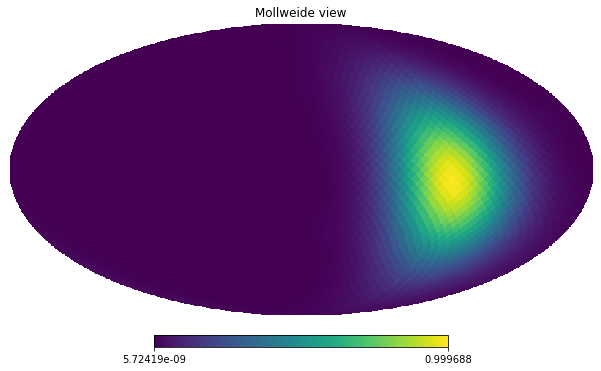

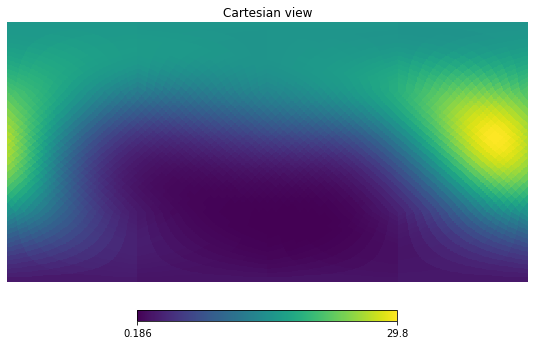

In [86]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord

beam = hp.fitsfunc.read_map('gaussian_beam_norm.fits')
#say we have a series of telescope pointing directions in celestial/equatorial coordinates:
nsteps = 100
ras = np.linspace(0, 360, nsteps) % 360
decs = np.linspace(0, 0, nsteps)
ls = np.zeros(nsteps)
bs = np.zeros(nsteps)
#first, we want the path of the beam in galactic coordinates:
for i in range(nsteps):
    c = SkyCoord(ras[i], decs[i], frame='icrs', unit='deg')
    ls[i] = c.galactic.l.degree
    bs[i] = c.galactic.b.degree
#rotate the beam so it starts at the proper position
rot = hp.Rotator(rot=([ls[0], bs[0], 0]), eulertype='ZYX')
beam = rot.rotate_map_pixel(beam)
hp.mollview(beam)
#then we can rotate (with ZYX euler angle convention) each angle to the next
sky_coverage = np.zeros_like(beam)
for i in range(nsteps):
    sky_coverage += beam
    if i != nsteps-1:
        rot = hp.Rotator(rot=([ls[i+1]-ls[i], bs[i+1]-bs[i], 0]), eulertype='ZYX')
        beam = rot.rotate_map_pixel(beam)
hp.cartview(sky_coverage)

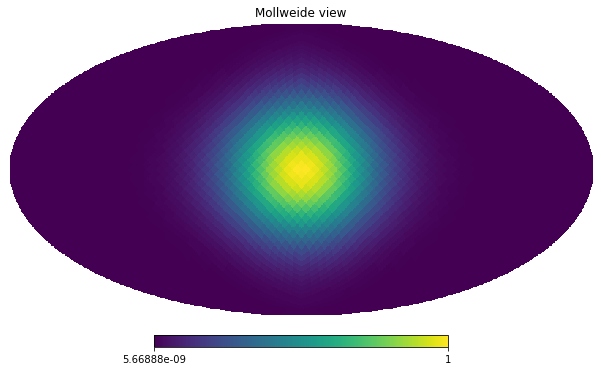

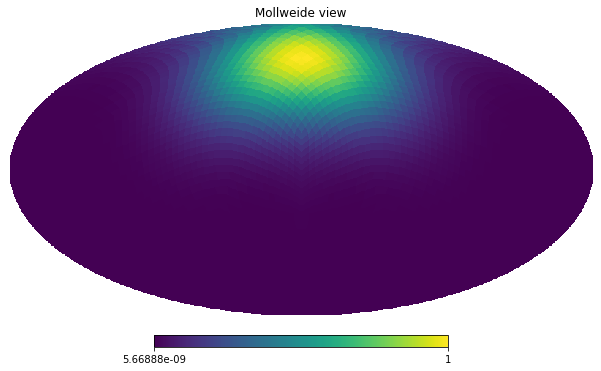

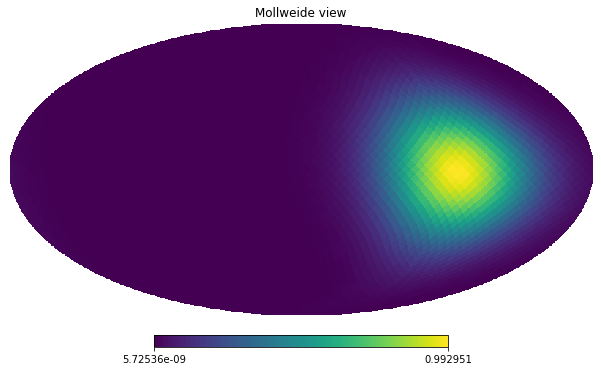

In [81]:
beam = hp.fitsfunc.read_map('gaussian_beam_norm.fits')
hp.mollview(beam)
hp.mollview(beam, rot=[0, -60])
rot = hp.Rotator(rot=([ls[0],-10, 0]), eulertype='ZYX')
beam = rot.rotate_map_pixel(beam)
hp.mollview(beam)